## Advanced Lane Finding Project

The goals / steps of this project are the following:

1. [Camera Calibration](#calibration)
2. [Distortion Correction](#distortion)
3. [Tranformations To A Binary Image](#transformations)
4. [Perspective Transform](#perspective)
5. [Detect Line Boundaries](#boundaries)
5. [Lane Curvature & Vehicle Center](#curvature)
5. [Unwarp Image](#unwarp)
7. [Render Lane Lines](#render)

---

## Camera Calibration <a name="calibration"></a>

Goal: Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

In [2]:
import os
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

In [3]:
DEBUG = True
SHOW_IMAGES = False

if DEBUG:
    images = glob.glob('./test_images/*')

In [4]:
def calibrate_camera(nx, ny, images, DEBUG = False, SHOW_IMAGES = False):
    
    """
    Calibrate camera using a set of calibration images with chessboards.
    Returns:
        mtx: Camera Matrix
        dist: Distortion coefficients
    """

    # 3-D points: (x, y, z)
    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Step through the list and search for chessboard corners
    for i in range(0, len(images)):
        
        # Read Image
        img = cv2.imread(images[i])
        
        # Convert to Gray Scale
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
        
        if (DEBUG):
            print(f"Image {images[i]} ({i}/{len(images)}) - Corners Found: {ret}")

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
            plt.imsave(f'./output_images/calibration/calibration_{i}.jpg', img)
                   
    # Calibrate Camera using object points and image points
    # ret, mtx, dist, rvecs, tvecs - Ignoring irrelvant outputs for this project
    _, mtx, dist, _, _ = cv2.calibrateCamera(objpoints, imgpoints, 
                                             gray.shape[::-1],None,None)
    
    
    # Return Camera matrix and distortion coefficients
    return mtx, dist

In [5]:
if DEBUG:
    # Make a list of calibration images

    cal_images = glob.glob('./camera_cal/calibration*.jpg')
    mtx, dist = calibrate_camera(9, 6, cal_images, DEBUG, SHOW_IMAGES)

Image ./camera_cal/calibration3.jpg (0/20) - Corners Found: True
Image ./camera_cal/calibration9.jpg (1/20) - Corners Found: True
Image ./camera_cal/calibration12.jpg (2/20) - Corners Found: True
Image ./camera_cal/calibration20.jpg (3/20) - Corners Found: True
Image ./camera_cal/calibration16.jpg (4/20) - Corners Found: True
Image ./camera_cal/calibration13.jpg (5/20) - Corners Found: True
Image ./camera_cal/calibration14.jpg (6/20) - Corners Found: True
Image ./camera_cal/calibration2.jpg (9/20) - Corners Found: True
Image ./camera_cal/calibration11.jpg (10/20) - Corners Found: True
Image ./camera_cal/calibration17.jpg (11/20) - Corners Found: True
Image ./camera_cal/calibration1.jpg (12/20) - Corners Found: False
Image ./camera_cal/calibration19.jpg (13/20) - Corners Found: True
Image ./camera_cal/calibration10.jpg (14/20) - Corners Found: True
Image ./camera_cal/calibration5.jpg (15/20) - Corners Found: False
Image ./camera_cal/calibration15.jpg (16/20) - Corners Found: True
Image 

## Distortion Correction <a name="distortion"></a>

Goal: Apply a distortion correction to raw images.

In [10]:
def undistort_image(img, mtx, dist):
    
    """
    Undistorts the image after camera calibration.
    Returns:
        img: Undistorted Image
    """
    
    return cv2.undistort(img, mtx, dist, None, mtx)

In [101]:
if DEBUG:
    # Make a list of calibration images
    img = cv2.imread('./camera_cal/calibration1.jpg')
    test = undistort_image(img, mtx, dist)
    plt.imsave(f'./output_images/calibration/undistorted_chessboard.jpg', test)

## Transformation to Binary Image <a name="transformations"></a>
Goal: Use color transforms, gradients, etc., to create a thresholded binary image.

In [11]:
# Helper Functions
def get_gradient(img, vertical_gradient = True, sobel_kernel=3):
    
    # Calculate the gradient
    return cv2.Sobel(img, cv2.CV_64F, vertical_gradient, not(vertical_gradient))

def scale_mtx_to_8bit(mtx):
    
    scale_factor = np.max(mtx)/255 
    return (mtx/scale_factor).astype(np.uint8) 

def apply_thresholds(mtx, threshold=(0,255), scale = False):
    
    # Scale the matrix to 8-bits
    base = scale_mtx_to_8bit(mtx) if scale else mtx

    # Prepare a binary matrix of equal size to the base
    binary = np.zeros_like(base)
    
    # Apply thresholds - "Activate" pixels that meet criteira
    binary[(base >= threshold[0]) & (base <= threshold[1])] = 1
    
    return binary

In [12]:
# Gradient
def apply_gradient_thresholds(gradient, threshold=(0,255)):
    
    # Get the absolute gradient
    abs_sobel = np.absolute(gradient)
    
    # Apply thresholds in a binary matrix
    return apply_thresholds(abs_sobel, threshold, scale = True)

# Magnitude
def apply_magnitude_thresholds(gradient_x, gradient_y, threshold=(0, 255)):
    
    # Calculate the gradient magnitude
    magnitude = np.sqrt(gradient_x**2 + gradient_y**2)
    
    # Apply thresholds in a binary matrix
    return apply_thresholds(magnitude, threshold, scale = True)

# Direction
def apply_direction_thresholds(gradient_x, gradient_y, threshold=(0, np.pi/2)):
    
    # Take the absolute value of the gradient direction, 
    
    abs_gradient_direction = np.arctan2(np.absolute(gradient_y), np.absolute(gradient_x))
    
    # Apply thresholds in a binary matrix
    return apply_thresholds(abs_gradient_direction, threshold)

In [13]:
# Gradient Pipeline
def apply_gradient_pipeline(img):
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Calculate the gradient
    sobel_x = get_gradient(gray, True, sobel_kernel = 7)
    sobel_y = get_gradient(gray, False, sobel_kernel = 7)

    gradient_x_mask = apply_gradient_thresholds(sobel_x, threshold = (20,220))
    direction_mask = apply_direction_thresholds(sobel_x, sobel_y, threshold = (40*np.pi/180, 70*np.pi/180))
    magnitude_mask = apply_magnitude_thresholds(sobel_x, sobel_y, threshold = (50, 200))
    
    combined = np.zeros_like(direction_mask)
    combined[(gradient_x_mask == 1) & ((magnitude_mask == 1) & (direction_mask == 1))] = 1
    
    return combined

In [103]:
if DEBUG:
    
    images = glob.glob('./test_images/*')
    
    img = cv2.imread(images[1])
    RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    undist = undistort_image(RGB_img, mtx, dist)
    plt.imsave(f'./output_images/image_pipeline/undistorted.jpg', undist)
    
    gray = cv2.cvtColor(undist, cv2.COLOR_RGB2GRAY)

    # Calculate the gradient
    sobel_x = get_gradient(gray, True, sobel_kernel = 7)
    sobel_y = get_gradient(gray, False, sobel_kernel = 7)

    gradient_x_mask = apply_gradient_thresholds(sobel_x, threshold = (20,220))
    plt.imsave(f'./output_images/image_pipeline/gradient_x_mask.jpg', gradient_x_mask, cmap='gray')
    
    direction_mask = apply_direction_thresholds(sobel_x, sobel_y, threshold = (40*np.pi/180, 70*np.pi/180))
    plt.imsave(f'./output_images/image_pipeline/direction_mask.jpg', direction_mask, cmap='gray')
    
    magnitude_mask = apply_magnitude_thresholds(sobel_x, sobel_y, threshold = (50, 200))
    plt.imsave(f'./output_images/image_pipeline/magnitude_mask.jpg', magnitude_mask, cmap='gray')
    
    combined = np.zeros_like(direction_mask)
    combined[(gradient_x_mask == 1) & ((magnitude_mask == 1) & (direction_mask == 1))] = 1
    plt.imsave(f'./output_images/image_pipeline/combined_gradient.jpg', combined, cmap='gray')
    

In [14]:
# Color
def apply_red_threshold(img, threshold = (0, 255)):
    
    R = img[:,:,0]
    return apply_thresholds(R, threshold)

def apply_saturation_threshold(img, threshold = (0, 255)):
    
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    S = hls[:,:,2]
    return apply_thresholds(S, threshold)

def apply_color_pipeline(img):
    
    R_mask = apply_red_threshold(img, (210,255))
    S_mask = apply_saturation_threshold(img, (90, 255))
    
    combined = np.zeros_like(S_mask)
    combined[(R_mask == 1) & (S_mask == 1)] = 1
    
    return combined

In [15]:
def get_thresholded_image(img):

    gradient_masks = apply_gradient_pipeline(img)
    color_masks = apply_color_pipeline(img)
    
    combined = np.zeros_like(color_masks)
    combined[(gradient_masks == 1) | (color_masks == 1)] = 1
    
    return combined

In [14]:
if DEBUG:
    
    images = glob.glob('./test_images/*')
    
    # Make a list of calibration images
    img = cv2.imread(images[1])
    undist = undistort_image(img, mtx, dist)
    
    thresholded = get_thresholded_image(undist)
    plt.imsave(f'./output_images/image_pipeline/final_gradient.jpg', thresholded, cmap='gray')

## Perspective Transform <a name="perspective"></a>
Goal: Apply a perspective transform to rectify binary image ("birds-eye view").

In [16]:
def apply_perspective_transform(img, src, dst):
    
    img_size = (img.shape[1], img.shape[0])
    
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    return M, Minv, warped

def apply_lane_birds_eye_view(img):
    
    height = img.shape[0]
    width = img.shape[1]

    src = np.float32([[280,  700],  # Bottom left
                      [595,  460],  # Top left
                      [725,  460],  # Top right
                      [1125, 700]]) # Bottom right

    dst = np.float32([[width*.2,  height],  # Bottom left
                      [width*.2,  0],  # Top left
                      [width*.8,  0],  # Top right
                      [width*.8, height]]) # Bottom right   

    return apply_perspective_transform(img, src, dst)


In [17]:
def draw_lines_from_points(img, points, color=[255, 0, 0], thickness=3):
    
    for i in range (0, len(points)):
        x1,y1 = points[i]
        x2,y2 = points[i+1] if i+1 < len(points) else points[0]

        cv2.line(img, (x1, y1), (x2, y2), color, thickness)

In [23]:
if DEBUG:
    
    # Make a list of calibration images
    img = cv2.imread(images[1])
    RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    undist = undistort_image(RGB_img, mtx, dist)
    
    height = img.shape[0]
    width = img.shape[1]
    
    src = np.float32([[235,  700],  # Bottom left
                      [595,  460],  # Top left
                      [725,  460],  # Top right
                      [1130, 700]]) # Bottom right

    dst = np.float32([[width*.2,  height],  # Bottom left
                      [width*.2,  0],  # Top left
                      [width*.8,  0],  # Top right
                      [width*.8, height]]) # Bottom right  
    
    M, Minv, warped = apply_lane_birds_eye_view(undist)
    
    draw_lines_from_points(RGB_img, src)
    plt.imsave(f'./output_images/image_pipeline/lane_original.jpg', RGB_img)
    
    draw_lines_from_points(warped, dst)
    plt.imsave(f'./output_images/image_pipeline/bird_eye.jpg', warped)

## Detect Line Boundaries <a name="boundaries"></a>
Goal: Detect lane pixels and fit to find the lane boundary.

In [18]:
def get_activation_peaks(img):
    
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)

    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    return histogram, leftx_base, rightx_base

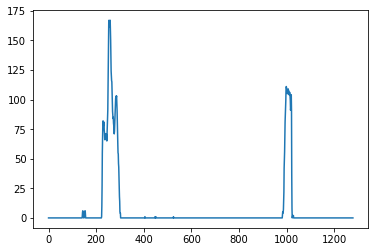

In [26]:
if DEBUG:
    
    images = glob.glob('./test_images/*')
    
    img = cv2.imread(images[1])

    # Step 1: Undistoring Image
    processed_image = undistort_image(img, mtx, dist)

    # Step 2: Applying Thresholds
    processed_image = get_thresholded_image(processed_image) 

    # Step 3: Changing Perspective
    M, Minv, processed_image = apply_lane_birds_eye_view(processed_image)
    
    histogram, leftx_base, rightx_base = get_activation_peaks(processed_image)
    
    plt.plot(histogram)
    plt.savefig(f'./output_images/image_pipeline/histogram.jpg')

In [19]:
def fit_second_degree_polynomial(x, y, img_shape):

    # Fit a second order polynomial to each using `np.polyfit`
    fit = np.polyfit(y, x, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0] )
    
    # x = A*y^2 + B*y + C
    fit_x = fit[0]*ploty**2 + fit[1]*ploty + fit[2]

    return fit, fit_x, ploty

In [77]:
def find_lane_pixels(img, SHOW_IMAGES = False):
      
    # Starting positions to be updated later for each window in nwindows
    histogram, leftx_current, rightx_current = get_activation_peaks(img)
    
    nwindows = 9 # Number of sliding windows
    margin = 110 # Width of the windows +/- margin
    minpix = 50 # Minimum number of pixels found to recenter window

    # Set height of windows - split height by number of windows
    window_height = np.int(img.shape[0]//nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Output Image
    out_img = np.dstack((img, img, img))*255

    # Step through the windows one by one
    for window in range(nwindows):
        
        # Vertical Boundaries
        win_y_low = img.shape[0] - (window + 1) * window_height
        win_y_high = img.shape[0] - window * window_height
        
        # Left Lane -----------------------------------------------------------
        win_xleft_low = leftx_current - margin # Left Lane - Left Boundary
        win_xleft_high = leftx_current + margin # Left Lane - Right Boundary
        
        # Identify the nonzero pixels in x and y within the window #        
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        
        left_lane_inds.append(good_left_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        
        # Right Lane -----------------------------------------------------------
        win_xright_low = rightx_current - margin # Right Lane - Left Boundary
        win_xright_high = rightx_current + margin # Right Lane - Right Boundary
        
        # Identify the nonzero pixels in x and y within the window #        
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        right_lane_inds.append(good_right_inds)
            
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            
        if SHOW_IMAGES:      
            # Draw the windows on the visualization image         
            cv2.rectangle(out_img, (win_xleft_low,win_y_low),(win_xleft_high,win_y_high), (0,255,0), 3) 
            cv2.rectangle(out_img, (win_xright_low,win_y_low),(win_xright_high,win_y_high), (0,255,0), 3) 
    
    # Extract left and right line pixel positions
    left_lane_inds = np.concatenate(left_lane_inds)
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    
    right_lane_inds = np.concatenate(right_lane_inds)
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

In [20]:
def detect_lane_lines(img, SHOW_IMAGES = False):
    
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(img, SHOW_IMAGES = SHOW_IMAGES)
    
    plt.imsave(f'./output_images/image_pipeline/test.jpg', out_img)
    
    if SHOW_IMAGES:
        out_img[lefty, leftx] = [255, 0, 0]
        out_img[righty, rightx] = [0, 0, 255]

    left_fit, left_fitx , _ = fit_second_degree_polynomial(leftx, lefty, out_img.shape)
    right_fit, right_fitx, ploty = fit_second_degree_polynomial(rightx, righty, out_img.shape)
    
    if SHOW_IMAGES:
        
        # Plot the polynomial lines onto the image
        left_line = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        cv2.polylines(out_img, np.int_([left_line]), False, (255,255,0), 3)
        
        right_line = np.array([np.transpose(np.vstack([right_fitx, ploty]))])
        cv2.polylines(out_img, np.int_([right_line]), False, (255,255,0), 3)   
    
    return (left_fit, right_fit), (left_fitx, right_fitx), out_img

In [21]:
def detect_lane_lines_bias(img, left_fit, right_fit, SHOW_IMAGES = False):
    
    margin = 100 # Width of the windows +/- margin
    
    if left_fit is None or right_fit is None:
        return detect_lane_lines(img)
        
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Get the left lane from polynomial fit
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    
    # Get the right lane from polynomial fit
    x_right_low = right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin
    x_right_high = right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin
    right_lane_inds = ((nonzerox > x_right_low) & (nonzerox < x_right_high))
    
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Ensure exhaustive search is performed if any lane dissapears
    if (leftx.size == 0 or rightx.size == 0):
        return detect_lane_lines(img)

    # Fit new polynomials   
    left_fit, left_fitx, _ = fit_second_degree_polynomial(leftx, lefty, img.shape[:2])
    right_fit, right_fitx, ploty = fit_second_degree_polynomial(rightx, righty, img.shape[:2])
    
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((img, img, img))*255
    
    if SHOW_IMAGES:
  
        window_img = np.zeros_like(out_img)

        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        out_img = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

        # Plot the polynomial lines onto the image
        left_line = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        cv2.polylines(out_img, np.int_([left_line]), False, (255,255,0), 3)
        
        right_line = np.array([np.transpose(np.vstack([right_fitx, ploty]))])
        cv2.polylines(out_img, np.int_([right_line]), False, (255,255,0), 3) 
    
    return (left_fit, right_fit), (left_fitx, right_fitx), out_img

In [88]:
if DEBUG:
    
    # Make a list of calibration images
    img = cv2.imread(images[1])
    
    # Step 1: Undistoring Image
    processed_image = undistort_image(img, mtx, dist)

    # Step 2: Applying Thresholds
    processed_image = get_thresholded_image(processed_image) 

    # Step 3: Changing Perspective
    M, Minv, processed_image = apply_lane_birds_eye_view(processed_image)
    
    line_fit, _, out_img = detect_lane_lines(processed_image, SHOW_IMAGES=True)
    plt.imsave(f'./output_images/image_pipeline/detect_lane.jpg', out_img)
    
    line_fit, _, out_img = detect_lane_lines_bias(processed_image, line_fit[0], line_fit[1], SHOW_IMAGES=True)
    plt.imsave(f'./output_images/image_pipeline/detect_lane2.jpg', out_img)
    

## Lane Curvature & Vehicle Center <a name="curvature"></a>
Goal: Determine the curvature of the lane and vehicle position with respect to center.

In [22]:
def get_curvature_radius(x, img_shape):
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    ploty = np.linspace(0, img_shape[0] - 1, img_shape[0])
    
    fit = np.polyfit(ploty*ym_per_pix, x*xm_per_pix, 2)       
    y_eval = np.max(ploty)
    
    # Calculation of R_curve (radius of curvature)
    curve_rad = ((1 + (2*fit[0]*y_eval*ym_per_pix + fit[1])**2)**1.5) / np.absolute(2*fit[0])
    
    return curve_rad

In [90]:
def get_lanes_curvature(left_x, right_x, img_shape):
    
    left_cr = get_curvature_radius(left_x, img_shape)
    right_cr = get_curvature_radius(right_x, img_shape)
    
    return left_cr, right_cr

In [23]:
def get_car_offset(left_lane, right_lane, img_shape):
    
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    mid_offset = (img_shape[1] - left_lane - right_lane)//2
    
    return mid_offset * xm_per_pix    

## Unwarp image <a name="unwarp"></a>
Goal: Warp the detected lane boundaries back onto the original image.

In [92]:
def restore_perspective(img, Minv):
    
    img_size = (img.shape[1], img.shape[0])
    
    return cv2.warpPerspective(img, Minv, img_size, flags=cv2.INTER_LINEAR)

## Render Lane Lines <a name="render"></a>
Goal: Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [93]:
def highlight_lane(img, left_x, right_x, img_shape):
    
    # Create an image to draw the lines on
    window_img = np.zeros_like(img).astype(np.uint8)
    out_img = np.dstack((img, img, img))
    
    ploty = np.linspace(0, img_shape[0] - 1, img_shape[0])

    left_margin = np.array([np.transpose(np.vstack([left_x, ploty]))])
    right_margin = np.array([np.flipud(np.transpose(np.vstack([right_x, ploty])))])
    lane = np.hstack((left_margin, right_margin))

    # Draw the lane
    cv2.fillPoly(out_img, np.int_([lane]), (0,255, 0))
    
    return out_img

In [94]:
def add_metrics(img, left_x, right_x):
    
    size = 1.5
    color = (255, 255, 255)
    thickness = 3
    font = cv2.FONT_HERSHEY_PLAIN
    
    # Calculate metrics
    left_curvature_radius = get_curvature_radius(left_x, img.shape)
    right_curvature_radius = get_curvature_radius(right_x, img.shape)

    # Display lane curvature
    cv2.putText(img, 'Left radius of curvature: {:.2f} m'.format(left_curvature_radius), 
                (50, 50), cv2.FONT_HERSHEY_SIMPLEX, size, color, thickness)
    cv2.putText(img, 'Right radius of curvature: {:.2f} m'.format(right_curvature_radius), 
                (50, 100), cv2.FONT_HERSHEY_SIMPLEX, size, color, thickness)
    
    # Calculate car offser
    offset = get_car_offset(left_x[-1], right_x[-1], img.shape)
    
    # Display car offset
    cv2.putText(img, 'Vehicle is {:.2f} m left of center'.format(offset), 
                (50, 150), cv2.FONT_HERSHEY_SIMPLEX, size, color, thickness)
    

# Final Pipeline

In [95]:
class LaneDetector:
    def __init__(self, nx, ny, calibration_path):
        
        cal_images = glob.glob(calibration_path)
        self.mtx, self.dist = calibrate_camera(nx, ny, cal_images, DEBUG, SHOW_IMAGES)
    
        self.line_fit = (None, None)

    def __call__(self, img): 

        # Step 1: Undistoring Image
        processed_image = undistort_image(img, self.mtx, self.dist)

        # Step 2: Applying Thresholds
        processed_image = get_thresholded_image(processed_image) 

        # Step 3: Changing Perspective
        M, Minv, processed_image = apply_lane_birds_eye_view(processed_image)

        # Step 4: Detect Lines
        self.line_fit, line_points, _ = detect_lane_lines_bias(processed_image, *self.line_fit,                                                           
                                                               SHOW_IMAGES = False)

        # Step 5: Highlight Lane
        lane = highlight_lane(processed_image, line_points[0], line_points[1], processed_image.shape[:2])

        # Step 6: Unwarp lane and add to main image
        unwarped_lane = restore_perspective(lane, Minv) 
        final_image = cv2.addWeighted(img, 1, unwarped_lane, 0.3, 0)

        # Step 7: Add Metrics
        add_metrics(final_image, line_points[0], line_points[1])

        return final_image

## Setup

In [96]:
# Make a list of calibration images
base_dir = "test_images/"
lane_detector = LaneDetector(9, 6, './camera_cal/calibration*.jpg')

Image ./camera_cal/calibration3.jpg (0/20) - Corners Found: True
Image ./camera_cal/calibration9.jpg (1/20) - Corners Found: True
Image ./camera_cal/calibration12.jpg (2/20) - Corners Found: True
Image ./camera_cal/calibration20.jpg (3/20) - Corners Found: True
Image ./camera_cal/calibration16.jpg (4/20) - Corners Found: True
Image ./camera_cal/calibration13.jpg (5/20) - Corners Found: True
Image ./camera_cal/calibration14.jpg (6/20) - Corners Found: True
Image ./camera_cal/calibration4.jpg (7/20) - Corners Found: False
Image ./camera_cal/calibration7.jpg (8/20) - Corners Found: True
Image ./camera_cal/calibration2.jpg (9/20) - Corners Found: True
Image ./camera_cal/calibration11.jpg (10/20) - Corners Found: True
Image ./camera_cal/calibration17.jpg (11/20) - Corners Found: True
Image ./camera_cal/calibration1.jpg (12/20) - Corners Found: False
Image ./camera_cal/calibration19.jpg (13/20) - Corners Found: True
Image ./camera_cal/calibration10.jpg (14/20) - Corners Found: True
Image ./c

## Process Test Images

In [97]:
for img_path in os.listdir(base_dir):
    
    output_dir = "output_images/"
    
    img = mpimg.imread(base_dir + img_path)
    processed_img = lane_detector(img)

    plt.imsave(output_dir + img_path, processed_img)

## Process Test Videos

In [98]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [99]:
output = 'output_videos/project_video.mp4'

clip1 = VideoFileClip("project_video.mp4")
clip = clip1.fl_image(lane_detector) 
%time clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video output_videos/project_video.mp4
[MoviePy] Writing video output_videos/project_video.mp4


100%|█████████▉| 1260/1261 [05:18<00:00,  4.07it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video.mp4 

CPU times: user 2min 59s, sys: 16.3 s, total: 3min 15s
Wall time: 5min 21s


In [100]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

In [ ]:
name = "challenge_video.mp4"
output = f'output_videos/{name}'

clip1 = VideoFileClip(name)
clip = clip1.fl_image(lane_detector) 
%time clip.write_videofile(output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

In [ ]:
name = "harder_challenge_video.mp4"
output = f'output_videos/{name}'

clip1 = VideoFileClip(name)
clip = clip1.fl_image(lane_detector) 
%time clip.write_videofile(output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))